In [19]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from generation.process.parametrization import GaussianParametrizer
from generation.train.vanila_gan import run_train, generate_new_signal
from scipy import signal
from sklearn.linear_model import Ridge
import tqdm

### Data preparation

In [20]:
# Data params
SAMPLE_SIZE = 100
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.00005

nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

### Data processing

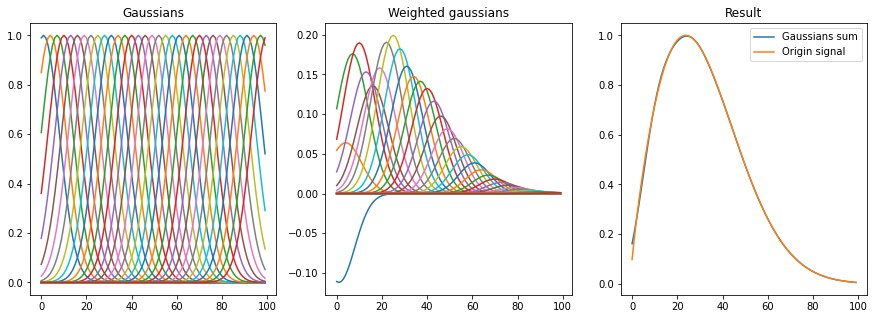

array([-0.1119169 ,  0.06394917,  0.17604464,  0.18971142,  0.1531987 ,
        0.13573964,  0.15823322,  0.19041682,  0.19911999,  0.18243849,
        0.16041263,  0.14754322,  0.14137745,  0.13224965,  0.11628265,
        0.09753831,  0.08144035,  0.06934193,  0.05911257,  0.04880602,
        0.03860987,  0.02985156,  0.02321046,  0.01822805,  0.01410904,
        0.01052192,  0.00760019,  0.00546119,  0.00394631,  0.00279648,
        0.00191127,  0.00134218,  0.00108839,  0.00099851])

In [57]:
### Parametrization params
GAUSSIAN_STD = 7
COMPRESS_COEF = 3
MODEL = Ridge(alpha=0.1, fit_intercept=False)

gaussian_parametrizer = GaussianParametrizer(COMPRESS_COEF, GAUSSIAN_STD, MODEL)
gaussian_parametrizer.transform_signal(data[0], to_visualize=True)

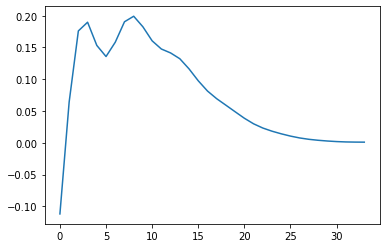

In [58]:
new_data = gaussian_parametrizer.transform_data(data)
plt.plot(new_data[0])
plt.show()

### Training

In [59]:
dataloader = DataLoader(new_data, batch_size=256, shuffle=True)

Iter-0; D_loss: -0.0004273839294910431; G_loss: -0.009873597882688046


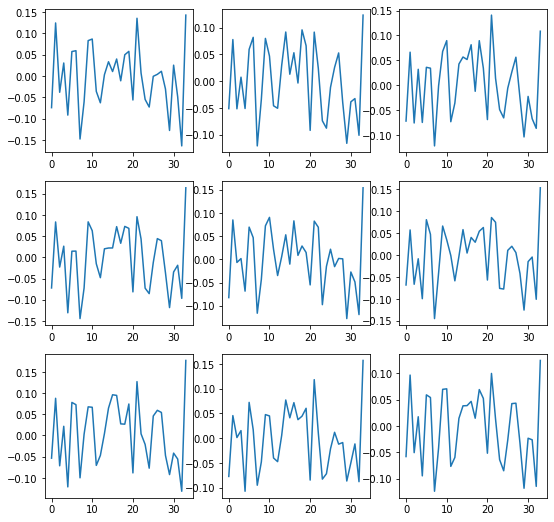

Iter-100; D_loss: -0.00014235731214284897; G_loss: -0.010059905238449574


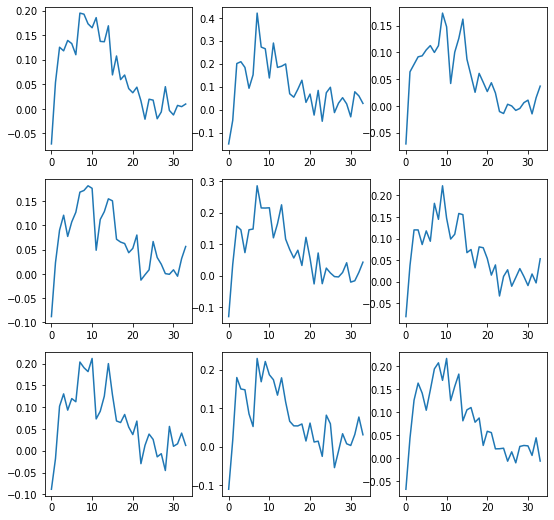

Iter-200; D_loss: -0.00011038221418857574; G_loss: -0.010166405700147152


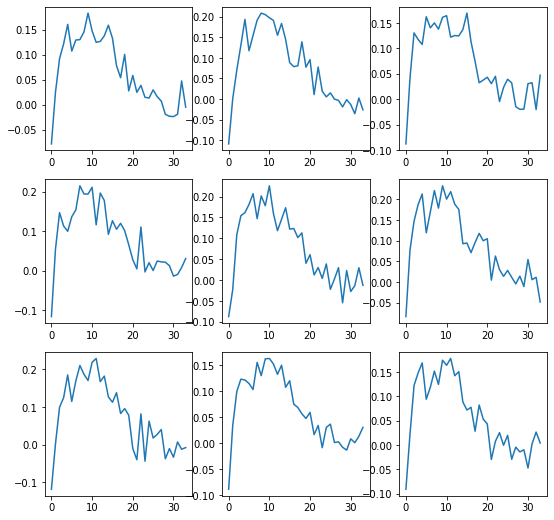

Iter-300; D_loss: -7.591024041175842e-05; G_loss: -0.010044042952358723


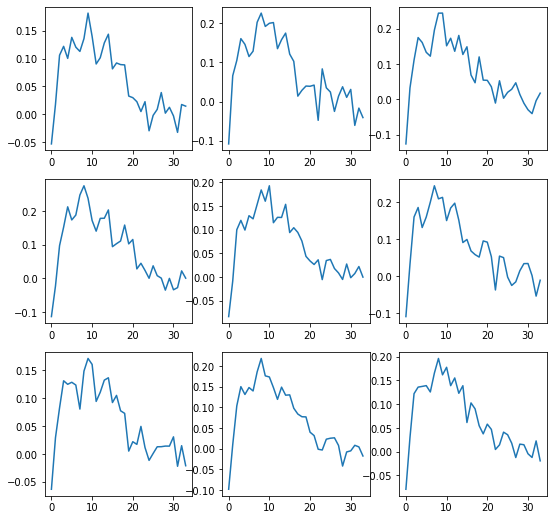

Iter-400; D_loss: -5.905516445636749e-05; G_loss: -0.009999585337936878


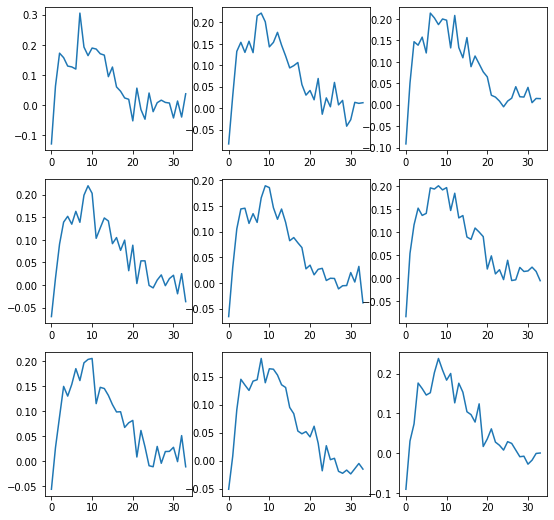

Iter-500; D_loss: -4.6912580728530884e-05; G_loss: -0.009918037801980972


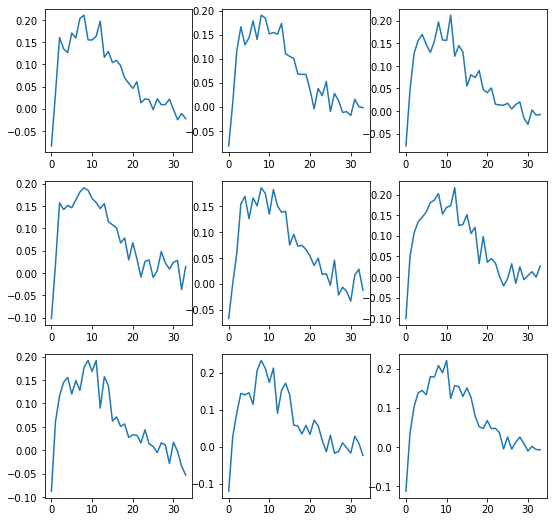

Iter-600; D_loss: -3.6881305277347565e-05; G_loss: -0.00996388029307127


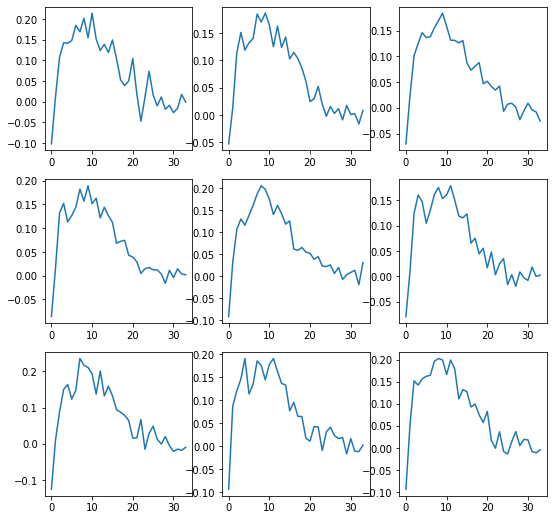

Iter-700; D_loss: -3.169849514961243e-05; G_loss: -0.009882507845759392


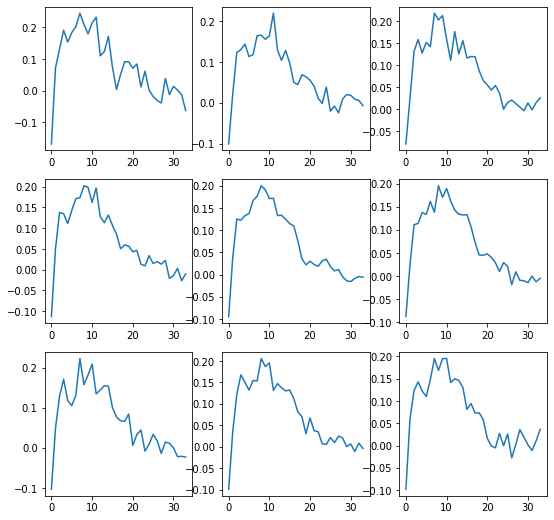

Iter-800; D_loss: -2.5185756385326385e-05; G_loss: -0.009848538786172867


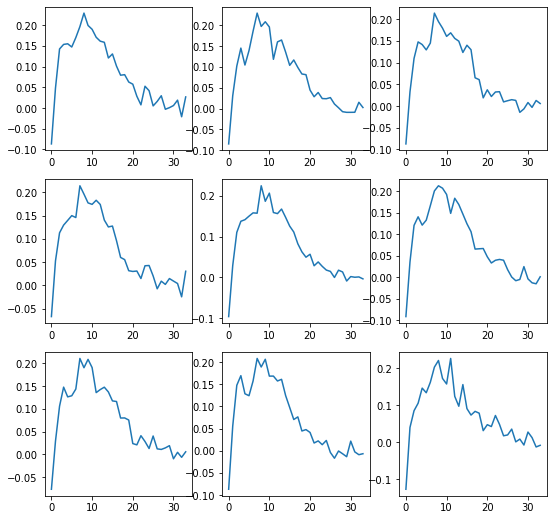

Iter-900; D_loss: -2.34898179769516e-05; G_loss: -0.009849246591329575


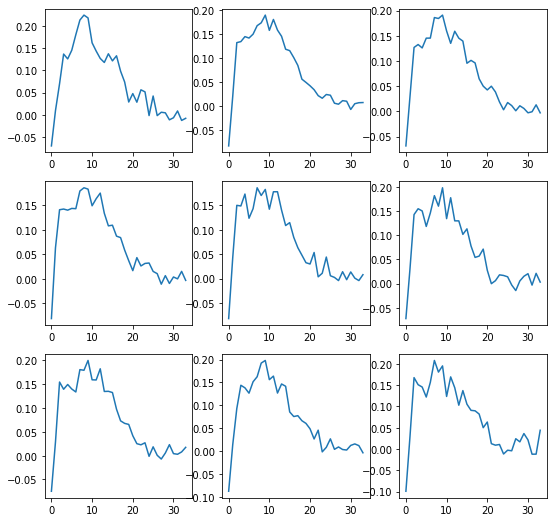

In [60]:
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable


mb_size = 128
z_dim = 20
X_dim = len(new_data[0])
h_dim = 32
cnt = 0
lr = 1e-4


G = torch.nn.Sequential(
    torch.nn.Linear(z_dim, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, X_dim),
    torch.nn.Tanh()
)


D = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
)


def reset_grad():
    G.zero_grad()
    D.zero_grad()


G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)


for epoch in range(1000):
    for _ in range(5):
        # Sample data
        z = Variable(torch.randn(mb_size, z_dim))
        X = Variable(next(iter(dataloader))).float()

        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Housekeeping - reset gradient
        reset_grad()


    # Generator forward-loss-backward-update
    X = Variable(next(iter(dataloader))).float()
    z = Variable(torch.randn(mb_size, z_dim))

    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if epoch % 100 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))

        rows_num = 3
        samples = G(z).data.numpy()[:rows_num**2]
        f, ax = plt.subplots(rows_num, rows_num, figsize=(rows_num**2, rows_num**2))
        for i, sample in enumerate(samples):
            ax[i//rows_num][i % rows_num].plot(sample)
        plt.show()


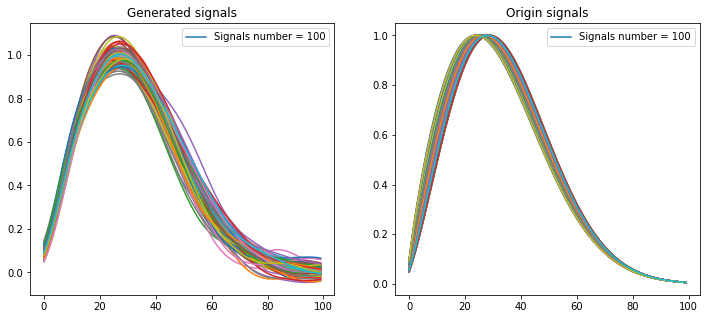

In [63]:
z = Variable(torch.randn(mb_size, z_dim))
samples = G(z).data.numpy()[:100]
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Generated signals")
ax[1].set_title("Origin signals")
for sample in samples:
    result = [0] * SAMPLE_SIZE
    gaussians = gaussian_parametrizer.gaussians
    for j in range(len(gaussians)):
        result += sample[j] * gaussians[j]
    ax[0].plot(result)
    ax[1].plot(data[np.random.choice(len(data))])
ax[0].legend(["Signals number = {}".format(len(samples))])
ax[1].legend(["Signals number = {}".format(len(samples))])
plt.show()

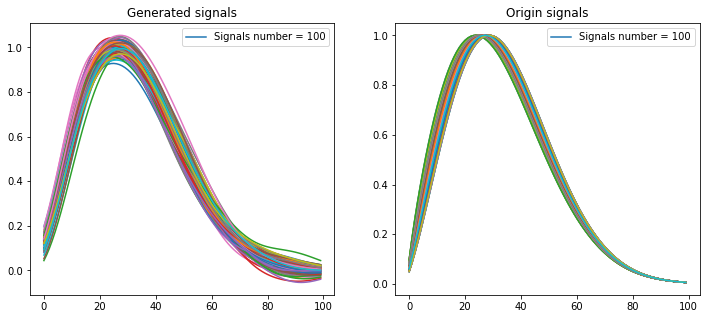

In [56]:
z = Variable(torch.randn(mb_size, z_dim))
samples = G(z).data.numpy()[:100]
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Generated signals")
ax[1].set_title("Origin signals")
for sample in samples:
    result = [0] * SAMPLE_SIZE
    gaussians = gaussian_parametrizer.gaussians
    for j in range(len(gaussians)):
        result += sample[j] * gaussians[j]
    ax[0].plot(result)
    ax[1].plot(data[np.random.choice(len(data))])
ax[0].legend(["Signals number = {}".format(len(samples))])
ax[1].legend(["Signals number = {}".format(len(samples))])
plt.show()

In [64]:
import statsmodels.tsa.api as smt
import pandas as pd
import statsmodels.api as sm

In [65]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=len(y)//2, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=len(y)//2, ax=pacf_ax, alpha=0.05)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/datadrive/anaconda3/lib/python3.7/site-package

Критерий Дики-Фуллера: p=0.017472


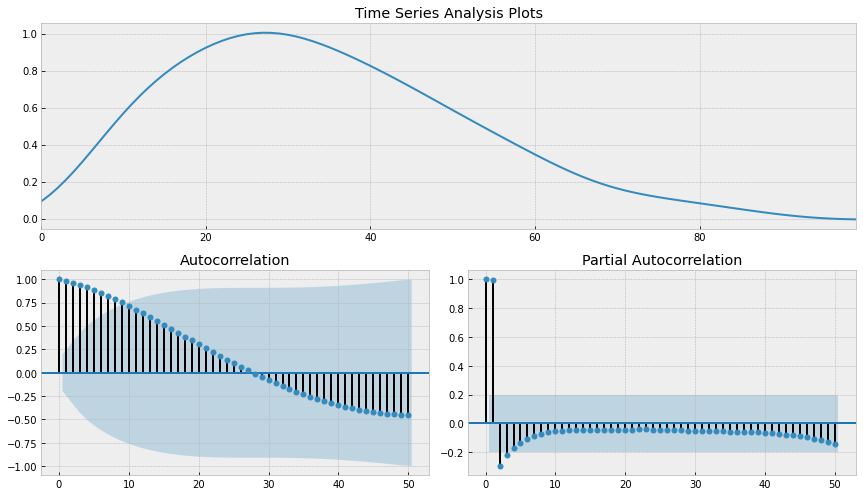

In [67]:
tsplot(result)

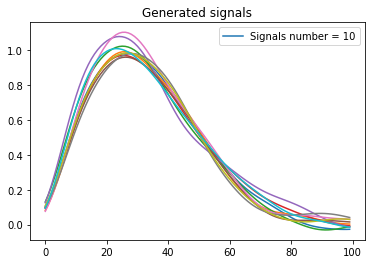

In [18]:
z = Variable(torch.randn(mb_size, z_dim))
samples = G(z).data.numpy()[:10]
plt.title("Generated signals")
for sample in samples:
    result = [0] * SAMPLE_SIZE
    gaussians = gaussian_parametrizer.gaussians
    for j in range(len(gaussians)):
        result += sample[j] * gaussians[j]
    plt.plot(result)
plt.legend(["Signals number = {}".format(len(samples))])
plt.show()

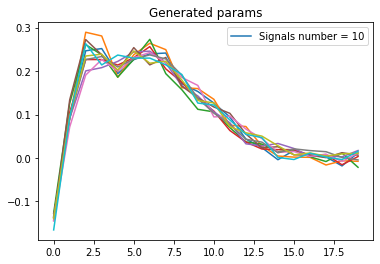

In [26]:
plt.title("Generated params")
for sample in samples:
    plt.plot(sample)
plt.legend(["Signals number = {}".format(len(samples))])
plt.show()

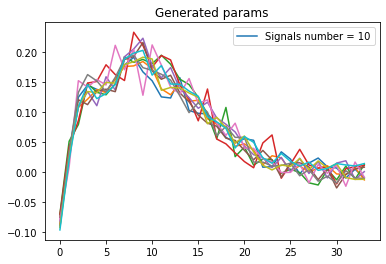

In [17]:
plt.title("Generated params")
for sample in samples:
    plt.plot(sample)
plt.legend(["Signals number = {}".format(len(samples))])
plt.show()